# 6章 物流の最適ルートをコンサルティングする１０本ノック

ここでは、「物流」の基礎となる「輸送最適化」を検討するにあたっての基礎的な技術を習得します。  
実際の物流データからネットワーク構造を可視化する方法について学び、最適な物流計画を立案する流れを学んでいきます。

### ノック５１：物流に関するデータを読み込んでみよう

In [1]:
import pandas as pd


factories = pd.read_csv('tbl_factory.csv', index_col=0)
factories

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,東京工場,28,関東
FC00002,木更津工場,29,関東
FC00003,多摩工場,31,関東
FC00004,横須賀工場,25,関東
FC00005,仙台工場,21,東北
FC00006,山形工場,30,東北
FC00007,那須工場,25,東北
FC00008,青森工場,16,東北


In [2]:
warehouses = pd.read_csv('tbl_warehouse.csv', index_col=0)
warehouses

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,杉並倉庫,35,関東
WH00002,品川倉庫,41,関東
WH00003,豊洲倉庫,42,関東
WH00004,郡山倉庫,60,東北
WH00005,仙台倉庫,72,東北
WH00006,山形倉庫,65,東北


In [3]:
cost = pd.read_csv('rel_cost.csv', index_col=0)
cost.head()

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [4]:
trans = pd.read_csv('tbl_transaction.csv', index_col=0)
trans.head()

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


In [5]:
joined_data = pd.merge(trans, cost, left_on=['ToFC', 'FromWH'], right_on=['FCID', 'WHID'], how='left')
joined_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


In [6]:
joined_data = pd.merge(joined_data, factories, left_on='ToFC', right_on='FCID', how='left')
joined_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東


In [7]:
joined_data = pd.merge(joined_data, warehouses, left_on=['FromWH'], right_on=['WHID'])
joined_data = joined_data[['TransactionDate', 'Quantity', 'Cost', 'ToFC', 'FCName', 'FCDemand', 'FromWH', 'WHName', 'WHSupply', 'WHRegion']]
joined_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
2,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
3,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東
4,2019-01-03 20:23:03,17,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東


In [9]:
kanto = joined_data.loc[joined_data['WHRegion']=='関東']
kanto

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
2,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
3,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東
4,2019-01-03 20:23:03,17,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
...,...,...,...,...,...,...,...,...,...,...
3995,2019-12-26 15:51:46,12,0.8,FC00004,横須賀工場,25,WH00001,杉並倉庫,35,関東
3996,2019-12-27 07:46:13,15,1.2,FC00003,多摩工場,31,WH00001,杉並倉庫,35,関東
3997,2019-12-27 17:09:28,28,1.2,FC00003,多摩工場,31,WH00001,杉並倉庫,35,関東
3998,2019-12-30 12:29:42,22,0.9,FC00002,木更津工場,29,WH00001,杉並倉庫,35,関東


In [10]:
tohoku = joined_data.loc[joined_data['WHRegion']=='東北']
tohoku

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
721,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
722,2019-01-01 09:00:15,33,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
723,2019-01-01 14:12:51,21,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
724,2019-01-01 17:14:43,36,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
725,2019-01-02 11:30:12,26,1.4,FC00005,仙台工場,21,WH00006,山形倉庫,65,東北
...,...,...,...,...,...,...,...,...,...,...
3321,2019-12-30 18:44:50,24,1.2,FC00007,那須工場,25,WH00005,仙台倉庫,72,東北
3322,2019-12-30 22:17:54,22,1.2,FC00007,那須工場,25,WH00005,仙台倉庫,72,東北
3323,2019-12-31 01:04:44,20,1.1,FC00006,山形工場,30,WH00005,仙台倉庫,72,東北
3324,2019-12-31 21:45:07,34,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北


### ノック５２：現状の輸送量、コストを確認してみよう

In [12]:
print('関東支社のコスト: ' + str(kanto['Cost'].sum()) + '万円')
print('東北支社のコスト: ' + str(tohoku['Cost'].sum()) + '万円')

関東支社のコスト: 2189.3万円
東北支社のコスト: 2062.0万円


In [13]:
print('関東支社の総部品輸送個数: ' + str(kanto['Quantity'].sum()) + '個')
print('東北支社の総部品輸送個数: ' + str(tohoku['Quantity'].sum()) + '個')

関東支社の総部品輸送個数: 49146個
東北支社の総部品輸送個数: 50214個


In [17]:
print('関東支社の単位コスト: ' + str(kanto['Cost'].sum() / kanto['Quantity'].sum() * 10000) + '円')
print('東北支社の単位コスト: ' + str(tohoku['Cost'].sum() / tohoku['Quantity'].sum() * 10000) + '円')

関東支社の単位コスト: 445.46860375208564円
東北支社の単位コスト: 410.6424503126618円


In [20]:
cost_chk = pd.merge(cost, factories, on='FCID', how='left')
print('関東支社の平均輸送コスト: ' + str(cost_chk['Cost'].loc[cost_chk['FCRegion']=='関東'].mean())+'万円')
print('東北支社の平均輸送コスト: ' + str(cost_chk['Cost'].loc[cost_chk['FCRegion']=='東北'].mean())+'万円')

関東支社の平均輸送コスト: 1.075万円
東北支社の平均輸送コスト: 1.05万円


### ノック５３：ネットワークを可視化してみよう

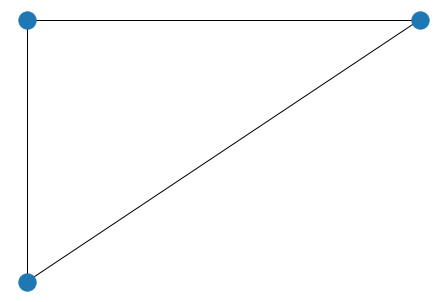

In [34]:
import networkx as nx
import matplotlib.pyplot as plt


G=nx.Graph()
G.add_node('nodeA')
G.add_node('nodeB')
G.add_node('nodeC')
G.add_edge('nodeA', 'nodeB')
G.add_edge('nodeA', 'nodeC')
G.add_edge('nodeB', 'nodeC')

pos={}
pos['nodeA']=(0, 0)
pos['nodeB']=(1, 1)
pos['nodeC']=(0, 1)

nx.draw(G, pos)
plt.show()

### ノック５４：ネットワークにノードを追加してみよう

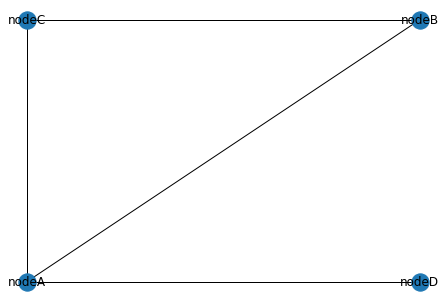

In [37]:
G.add_node('nodeD')

G.add_edge('nodeA', 'nodeD')
pos['nodeD']=(1,0)
nx.draw(G, pos, with_labels=True)


### ノック５５：ルートの重みづけを実施しよう

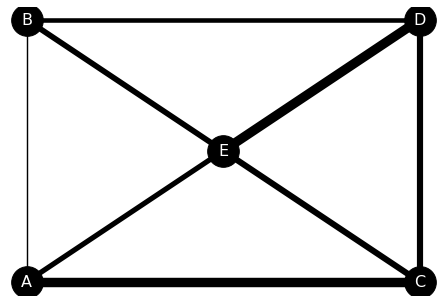

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


df_w = pd.read_csv('network_weight.csv')
df_p = pd.read_csv('network_pos.csv')

size = 10
edge_weights = []
for i in range(len(df_w)):
    for j in range(len(df_w.columns)):
        edge_weights.append(df_w.iloc[i][j] * size)

G = nx.Graph()

for i in range(len(df_w.columns)):
    G.add_node(df_w.columns[i])

for i in range(len(df_w.columns)):
    for j in range(len(df_w.columns)):
        G.add_edge(df_w.columns[i], df_w.columns[j])

pos = {}
for i in range(len(df_w.columns)):
    node = df_w.columns[i]
    pos[node] = (df_p[node][0], df_p[node][1])

nx.draw(G, pos, with_labels=True, font_size=16, node_size=1000, node_color='k', font_color='w', width=edge_weights)
plt.show()

### ノック５６：輸送ルート情報を読み込んでみよう

### ノック５７：輸送ルート情報からネットワークを可視化してみよう

### ノック５８：輸送コスト関数を作成しよう

### ノック５９：制約条件を作ってみよう

### ノック６０：輸送ルートを変更して、輸送コスト関数の変化を確認しよう